In [1]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import backend as K, metrics
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()
n = 2
multiTrack = False
context, x_train, labels = data.import_data(data.init(), n, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.3333333333333333
 >> Context(max_t=3.0, dt=0.02, n_instances=150, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Setting up params

max min f 25.0 0.3333333333333333
 >> Context(max_t=3.0, dt=0.02, n_instances=150, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = False
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.994791666666667
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9947916666666665
 |>  150


In [5]:
n = 100
min_f = 3
max_f = 15
# x_train = g.gen_data(context, n, max_f=max_f, min_f=min_f)
x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f, multiTrack=multiTrack)
y_train = x_train
x_test = x_train[-10:]
x_train = x_train[:-10]

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9947916666666696
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0083333333333337
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0166666666666697
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9979166666666686
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.991666666666668
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.99479166666667
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.005208333333334
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9916666666666702
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.003125000000001
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9927083333333337
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.995833333333335
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0000000000000027
 |>  150
 [DEBUG] >

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.002083333333334
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0052083333333384
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0072916666666694
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.990625000000002
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.991666666666669
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9958333333333353
 |>  150


In [6]:
x_train.shape

(272, 150, 1)

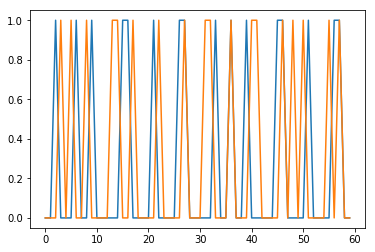

In [7]:
plt.plot(x_train[0,:60])
plt.plot(x_train[1,:60])

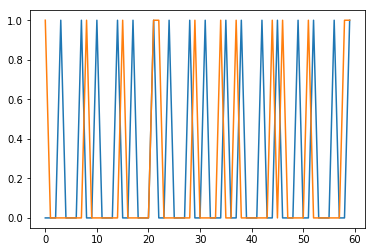

In [8]:
plt.plot(x_train[2,:60])
plt.plot(x_train[3,:60])

In [9]:
x_train.shape

(272, 150, 1)

In [10]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:] # shape of a single sample
# output_length = y_train.shape[1:][0]
input_shape

(150, 1)

In [11]:
output_shape

(150, 1)

In [12]:
num_encoder_tokens = x_train.shape[-1]
num_decoder_tokens = y_train.shape[-1]
# latent_dim = 1

In [14]:
input_shape
# input_shape = (150,)
input_shape

(150, 1)

In [17]:
batch_size = 32
original_dim = 150
latent_dim = 50
intermediate_dim = 150
epsilon_std = 1.0

In [18]:
# TODO Batch Normalization

In [35]:
def sampling(args, latent_dim, epsilon_std):
    z_mean, z_log_var = args
    # epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [36]:
k_reg = keras.regularizers.l2(1e-5)
# b_reg = keras.regularizers.l1(0.01)
a_reg = keras.regularizers.l1(1e-5)

def encoder(latent_dim, input_shape, intermediate_dim = 150):
    encoder_input = Input(shape=input_shape, name='encoder_input-')
    h = encoder_input
    # image_data_format = 'channels_last'   -   e.g. (28,28,3)
    # naive assumption:
    #   for drumkits no correlation between note_indices and occurrence at an timestep is assumed
    #   (that is, p(E|C) is not significantly different from p(D|C))
    #   - note that this _is_ the case for e.g. HH vs. OH
    #     these often occur in the same register (between different drumkits)
    #   - even with melodic/harmonic data, this assumption could help by reducing
    #    (1) unwanted repetition (stuttering) of notes
    #    (2) unwanted dissonance (caused by playing notes with an interval of a half step)
    
    timesteps = input_shape[-2]
    notes = input_shape[-1]
    
    # Convolve & Pool
#     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding='same')(h)
#     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding='same')(h)
#     h = MaxPooling1D(pool_size=2, strides=2, padding='same')(h)

    h = Conv1D(32, kernel_size=2, strides=2, activation='relu', padding='same')(h)
#     h = Conv1D(32, kernel_size=2, strides=1, activation='relu', padding='same')(h)
    h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='same')(h)
    h = MaxPooling1D(pool_size=2, strides=2, padding='same')(h)
    
#     h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='same')(h)
#     h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='same')(h)
#     h = MaxPooling1D(pool_size=2, strides=2, padding='same')(h)
#     # 128 512

    # Dense layers
    h = Flatten()(h)
    h = Dense(intermediate_dim, activation='relu')(h)
#     h = Dense(intermediate_dim, activation='relu')(h)
#     h = Dense(intermediate_dim, activation='relu')(h)    
#     h = Dropout(0.1)(h) # uncomment when using larger batches
#     h = Dense(intermediate_dim, activation='relu')(h)
    # h = Dense(intermediate_dim, activation='relu', kernel_regularizer=k_reg, activity_regularizer=a_reg)(h)

    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
    
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, z_mean, z_log_var, encoder_input

def z_(latent_dim, epsilon_std):
    # sample z from a distribution defined by [input_mean, input_log_var]
    # input :: [z_mean, z_log_var]
    z_input = [Input(shape=(latent_dim,)), Input(shape=(latent_dim,))]
    sampling_ = lambda args: sampling(args, latent_dim, epsilon_std)
    z_output = Lambda(sampling_, name='z_sampler-')(z_input)
    # z_output = Lambda(sampling_, output_shape=(latent_dim,), name='z_sampler-')(z_input)
    z_model = Model(z_input, z_output, name='z_model-')
    return z_model

def decoder(latent_dim, output_shape, filters = 32):
    z_input = Input(shape=(latent_dim,), name='decoder_input-')
    h = z_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # at the start of upsampling, the image-structure does not yet have to correspond to the goal structure 
    # ?TODO use y*y*y starting dims, may conv, and only then correct the structure (?)
    
    timesteps = output_shape[-2] # cols
    notes = output_shape[-1] # rows
    channels = 1 # rgb

    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    m = 4 # multiplier for dims
    output_shape = (channels, notes * m, timesteps)
    p = 'valid'

    # upsampling
    h = Dense(np.prod(output_shape[-3:]), activation='relu')(h)
    h = Reshape(output_shape[-3:])(h)
    
    # Convolve & Pool
    # Note that the kernel windows do not yet correspond to 'temporal' features, but rather to just spatial features
    k = (3,2) # (2,1) :: (timesteps, notes)
    s = (1,3)
    # TODO
    s1 = (3,1)
    s2 = (1,3)
    s3 = 2
    timesteps_ = int(timesteps / 2)
    h = Conv2DTranspose(timesteps_, kernel_size=k, strides=3, activation='relu', padding=p)(h)
    h = Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)(h)
#     h = Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)(h)
    h = Conv2DTranspose(16, kernel_size=k, strides=(3,1), activation='relu', padding=p)(h)
    h = MaxPooling2D(pool_size=2, strides=2, padding='same')(h)

#     h = Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)(h)
    h = Conv2DTranspose(16, kernel_size=k, strides=3, activation='relu', padding=p)(h)
    # 'end' of upsampling
    h = Conv2D(1, kernel_size=(1,2), strides=1, activation='relu', padding=p)(h)
    dims = keras.backend.int_shape(h)[1:]
    print('dims', dims)
    h = Reshape(dims[0:2])(h)
#     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding=p)(h)
    h = Conv1D(notes * m, kernel_size=2, strides=2, activation='relu', padding=p)(h)

    
    # Mean (output)
#     h = Conv2D(1, kernel_size=1, strides=s, activation='sigmoid', padding='same')(h)
    output_shape = (timesteps, notes)
    h = Flatten()(h)
    h = Dense(np.prod(output_shape), activation='sigmoid')(h)
    output_shape = (timesteps, notes)
    h = Reshape(output_shape)(h)
    decoder_output = h
    model = Model(inputs=z_input, outputs=decoder_output, name='decoder_model-')
    return model

In [37]:
encoder_model, z_mean, z_log_var, encoder_input = encoder(latent_dim, input_shape)
z_model = z_(latent_dim, epsilon_std)
decoder_model = decoder(latent_dim, output_shape)


encoder_model.summary()
z_model.summary()
decoder_model.summary()

dims (42, 56, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input- (InputLayer)     (None, 150, 1)       0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 75, 32)       96          encoder_input-[0][0]             
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 75, 64)       4160        conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 38, 64)       0           conv1d_8[0][0]                   
____________________________________________________________________________________________

In [38]:
vae_input = Input(shape=input_shape)
# vae_input = Input(shape=(150,1))
vae_input = encoder_input # WHY ?
vae_output = decoder_model(z_model(encoder_model(vae_input)))
# vae_output = decoder_model(z)
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input- (InputLayer)     (None, 150, 1)       0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 50), (None,  384306      encoder_input-[0][0]             
__________________________________________________________________________________________________
z_model- (Model)                (None, 50)           0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
decoder_model- (Model)          (None, 150, 1)       130482      z_model-[1][0]                   
Total para

In [39]:
def vae_loss(y_true, y_pred, z_mean, z_log_var):
    # img_rows * img_cols
    # xent_loss = K.binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
    xent_loss = K.binary_crossentropy(y_true, y_pred)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # kl_loss = - 0.5 * K.sum(1 + K.flatten(z_log_var) - K.square(K.flatten(z_mean)) - K.exp(K.flatten(z_log_var)), axis=-1)
    return xent_loss + kl_loss

In [40]:
metrics = ['acc','mse','mae','binary_crossentropy']
loss = lambda y_true, y_pred: vae_loss(y_true, y_pred, z_mean, z_log_var)
optimizer = 'rmsprop' # adam adadelta rmsprop nadam
# keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [41]:
# vae.add_loss(vae_loss)
# vae.compile(optimizer='rmsprop', metrics=['binary_accuracy','mae'])

In [29]:
# z_train = x_train
# x_train = x_train.reshape(x_train.shape[0],np.prod(x_train.shape[1:]))
x_train.shape

(272, 150, 1)

In [44]:
# z_train = x_train
# x = np.concatenate([x_train[0:2] for _ in range(1000)])
x.shape
# x_train = x

(2000, 150, 1)

In [45]:
epochs = 250
m = int(64*2 * 7/6)
vs = 1/6
shuffle = True
callbacks = []
callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
history = vae.fit(x_train[:m], x_train[:m], epochs=epochs, batch_size=batch_size,
          validation_split=vs, callbacks=callbacks, shuffle=shuffle)
# history = vae.fit(x_train[:m], shuffle=False, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 124 samples, validate on 25 samples
Epoch 1/250
124/124 [==============================] - 1s 5ms/step - loss: 0.6975 - acc: 0.6868 - mean_squared_error: 0.2491 - mean_absolute_error: 0.4991 - binary_crossentropy: 0.6913 - val_loss: 0.6866 - val_acc: 0.7629 - val_mean_squared_error: 0.2464 - val_mean_absolute_error: 0.4964 - val_binary_crossentropy: 0.6860
Epoch 2/250
124/124 [==============================] - 0s 3ms/step - loss: 0.6702 - acc: 0.7743 - mean_squared_error: 0.2385 - mean_absolute_error: 0.4879 - binary_crossentropy: 0.6701 - val_loss: 0.6043 - val_acc: 0.7771 - val_mean_squared_error: 0.2063 - val_mean_absolute_error: 0.4501 - val_binary_crossentropy: 0.6042
Epoch 3/250
124/124 [==============================] - 0s 3ms/step - loss: 0.5127 - acc: 0.7823 - mean_squared_error: 0.1681 - mean_absolute_error: 0.3851 - binary_crossentropy: 0.5126 - val_loss: 0.3569 - val_acc: 0.7979 - val_mean_squared_error: 0.1152 - val_mean_absolute_error: 0.2622 - val_binary_crossen

124/124 [==============================] - 0s 3ms/step - loss: 0.2758 - acc: 0.7798 - mean_squared_error: 0.0997 - mean_absolute_error: 0.1981 - binary_crossentropy: 0.2758 - val_loss: 0.2742 - val_acc: 0.8085 - val_mean_squared_error: 0.0989 - val_mean_absolute_error: 0.1974 - val_binary_crossentropy: 0.2742
Epoch 27/250
124/124 [==============================] - 0s 2ms/step - loss: 0.2737 - acc: 0.8089 - mean_squared_error: 0.0987 - mean_absolute_error: 0.1970 - binary_crossentropy: 0.2736 - val_loss: 0.2743 - val_acc: 0.7947 - val_mean_squared_error: 0.0990 - val_mean_absolute_error: 0.1973 - val_binary_crossentropy: 0.2743
Epoch 28/250
124/124 [==============================] - 0s 3ms/step - loss: 0.2756 - acc: 0.7817 - mean_squared_error: 0.0997 - mean_absolute_error: 0.1979 - binary_crossentropy: 0.2756 - val_loss: 0.2735 - val_acc: 0.7968 - val_mean_squared_error: 0.0986 - val_mean_absolute_error: 0.1969 - val_binary_crossentropy: 0.2735
Epoch 29/250
124/124 [===================

124/124 [==============================] - 0s 3ms/step - loss: 0.2749 - acc: 0.7973 - mean_squared_error: 0.0994 - mean_absolute_error: 0.1974 - binary_crossentropy: 0.2749 - val_loss: 0.2729 - val_acc: 0.7883 - val_mean_squared_error: 0.0984 - val_mean_absolute_error: 0.1969 - val_binary_crossentropy: 0.2729
Epoch 52/250
124/124 [==============================] - 0s 2ms/step - loss: 0.2731 - acc: 0.7992 - mean_squared_error: 0.0985 - mean_absolute_error: 0.1969 - binary_crossentropy: 0.2731 - val_loss: 0.2742 - val_acc: 0.7875 - val_mean_squared_error: 0.0991 - val_mean_absolute_error: 0.1974 - val_binary_crossentropy: 0.2742
Epoch 53/250
124/124 [==============================] - 0s 3ms/step - loss: 0.2739 - acc: 0.7927 - mean_squared_error: 0.0989 - mean_absolute_error: 0.1971 - binary_crossentropy: 0.2739 - val_loss: 0.2733 - val_acc: 0.8043 - val_mean_squared_error: 0.0986 - val_mean_absolute_error: 0.1970 - val_binary_crossentropy: 0.2733
Epoch 54/250
124/124 [===================

124/124 [==============================] - 0s 3ms/step - loss: 0.2739 - acc: 0.7927 - mean_squared_error: 0.0989 - mean_absolute_error: 0.1972 - binary_crossentropy: 0.2739 - val_loss: 0.2723 - val_acc: 0.8107 - val_mean_squared_error: 0.0981 - val_mean_absolute_error: 0.1965 - val_binary_crossentropy: 0.2723
Epoch 77/250
124/124 [==============================] - 0s 3ms/step - loss: 0.2728 - acc: 0.7994 - mean_squared_error: 0.0984 - mean_absolute_error: 0.1968 - binary_crossentropy: 0.2728 - val_loss: 0.2729 - val_acc: 0.8035 - val_mean_squared_error: 0.0985 - val_mean_absolute_error: 0.1968 - val_binary_crossentropy: 0.2729
Epoch 78/250
124/124 [==============================] - 0s 3ms/step - loss: 0.2732 - acc: 0.7912 - mean_squared_error: 0.0986 - mean_absolute_error: 0.1969 - binary_crossentropy: 0.2732 - val_loss: 0.2724 - val_acc: 0.8112 - val_mean_squared_error: 0.0982 - val_mean_absolute_error: 0.1965 - val_binary_crossentropy: 0.2724
Epoch 79/250
124/124 [===================

124/124 [==============================] - 0s 3ms/step - loss: 0.2732 - acc: 0.7858 - mean_squared_error: 0.0986 - mean_absolute_error: 0.1969 - binary_crossentropy: 0.2732 - val_loss: 0.2726 - val_acc: 0.8083 - val_mean_squared_error: 0.0983 - val_mean_absolute_error: 0.1966 - val_binary_crossentropy: 0.2726
Epoch 102/250
124/124 [==============================] - 0s 3ms/step - loss: 0.2736 - acc: 0.7762 - mean_squared_error: 0.0988 - mean_absolute_error: 0.1972 - binary_crossentropy: 0.2736 - val_loss: 0.2724 - val_acc: 0.8091 - val_mean_squared_error: 0.0982 - val_mean_absolute_error: 0.1965 - val_binary_crossentropy: 0.2724
Epoch 103/250
124/124 [==============================] - 0s 3ms/step - loss: 0.2737 - acc: 0.7997 - mean_squared_error: 0.0989 - mean_absolute_error: 0.1971 - binary_crossentropy: 0.2737 - val_loss: 0.2727 - val_acc: 0.8000 - val_mean_squared_error: 0.0983 - val_mean_absolute_error: 0.1967 - val_binary_crossentropy: 0.2727
Epoch 104/250
124/124 [================

124/124 [==============================] - 0s 3ms/step - loss: 0.2734 - acc: 0.8032 - mean_squared_error: 0.0987 - mean_absolute_error: 0.1970 - binary_crossentropy: 0.2734 - val_loss: 0.2724 - val_acc: 0.8133 - val_mean_squared_error: 0.0982 - val_mean_absolute_error: 0.1966 - val_binary_crossentropy: 0.2724
Epoch 127/250
124/124 [==============================] - 0s 3ms/step - loss: 0.2729 - acc: 0.8046 - mean_squared_error: 0.0985 - mean_absolute_error: 0.1968 - binary_crossentropy: 0.2729 - val_loss: 0.2729 - val_acc: 0.7896 - val_mean_squared_error: 0.0984 - val_mean_absolute_error: 0.1968 - val_binary_crossentropy: 0.2729
Epoch 128/250
124/124 [==============================] - 0s 3ms/step - loss: 0.2728 - acc: 0.7967 - mean_squared_error: 0.0984 - mean_absolute_error: 0.1968 - binary_crossentropy: 0.2728 - val_loss: 0.2727 - val_acc: 0.7995 - val_mean_squared_error: 0.0983 - val_mean_absolute_error: 0.1967 - val_binary_crossentropy: 0.2727
Epoch 129/250
124/124 [================

124/124 [==============================] - 0s 2ms/step - loss: 0.2727 - acc: 0.7970 - mean_squared_error: 0.0984 - mean_absolute_error: 0.1967 - binary_crossentropy: 0.2727 - val_loss: 0.2726 - val_acc: 0.8120 - val_mean_squared_error: 0.0983 - val_mean_absolute_error: 0.1966 - val_binary_crossentropy: 0.2726
Epoch 152/250
124/124 [==============================] - 0s 3ms/step - loss: 0.2729 - acc: 0.7939 - mean_squared_error: 0.0985 - mean_absolute_error: 0.1968 - binary_crossentropy: 0.2729 - val_loss: 0.2727 - val_acc: 0.8040 - val_mean_squared_error: 0.0984 - val_mean_absolute_error: 0.1967 - val_binary_crossentropy: 0.2727
Epoch 153/250
124/124 [==============================] - 0s 3ms/step - loss: 0.2732 - acc: 0.8033 - mean_squared_error: 0.0986 - mean_absolute_error: 0.1969 - binary_crossentropy: 0.2732 - val_loss: 0.2727 - val_acc: 0.7925 - val_mean_squared_error: 0.0984 - val_mean_absolute_error: 0.1967 - val_binary_crossentropy: 0.2727
Epoch 154/250
124/124 [================

124/124 [==============================] - 0s 2ms/step - loss: 0.2730 - acc: 0.7856 - mean_squared_error: 0.0985 - mean_absolute_error: 0.1969 - binary_crossentropy: 0.2730 - val_loss: 0.2727 - val_acc: 0.8088 - val_mean_squared_error: 0.0984 - val_mean_absolute_error: 0.1967 - val_binary_crossentropy: 0.2727
Epoch 177/250
124/124 [==============================] - 0s 2ms/step - loss: 0.2728 - acc: 0.8015 - mean_squared_error: 0.0984 - mean_absolute_error: 0.1968 - binary_crossentropy: 0.2728 - val_loss: 0.2726 - val_acc: 0.8053 - val_mean_squared_error: 0.0983 - val_mean_absolute_error: 0.1967 - val_binary_crossentropy: 0.2726
Epoch 178/250
124/124 [==============================] - 0s 2ms/step - loss: 0.2728 - acc: 0.7976 - mean_squared_error: 0.0984 - mean_absolute_error: 0.1968 - binary_crossentropy: 0.2728 - val_loss: 0.2726 - val_acc: 0.8080 - val_mean_squared_error: 0.0983 - val_mean_absolute_error: 0.1967 - val_binary_crossentropy: 0.2726
Epoch 179/250
124/124 [================

124/124 [==============================] - 0s 2ms/step - loss: 0.2731 - acc: 0.7930 - mean_squared_error: 0.0985 - mean_absolute_error: 0.1969 - binary_crossentropy: 0.2731 - val_loss: 0.2726 - val_acc: 0.8112 - val_mean_squared_error: 0.0983 - val_mean_absolute_error: 0.1966 - val_binary_crossentropy: 0.2726
Epoch 202/250
124/124 [==============================] - 0s 2ms/step - loss: 0.2727 - acc: 0.8026 - mean_squared_error: 0.0984 - mean_absolute_error: 0.1967 - binary_crossentropy: 0.2727 - val_loss: 0.2728 - val_acc: 0.7947 - val_mean_squared_error: 0.0984 - val_mean_absolute_error: 0.1967 - val_binary_crossentropy: 0.2728
Epoch 203/250
124/124 [==============================] - 0s 2ms/step - loss: 0.2730 - acc: 0.7809 - mean_squared_error: 0.0985 - mean_absolute_error: 0.1968 - binary_crossentropy: 0.2730 - val_loss: 0.2727 - val_acc: 0.8027 - val_mean_squared_error: 0.0983 - val_mean_absolute_error: 0.1967 - val_binary_crossentropy: 0.2727
Epoch 204/250
124/124 [================

124/124 [==============================] - 0s 2ms/step - loss: 0.2728 - acc: 0.7891 - mean_squared_error: 0.0984 - mean_absolute_error: 0.1967 - binary_crossentropy: 0.2728 - val_loss: 0.2727 - val_acc: 0.8075 - val_mean_squared_error: 0.0983 - val_mean_absolute_error: 0.1967 - val_binary_crossentropy: 0.2727
Epoch 227/250
124/124 [==============================] - 0s 2ms/step - loss: 0.2729 - acc: 0.7892 - mean_squared_error: 0.0984 - mean_absolute_error: 0.1968 - binary_crossentropy: 0.2729 - val_loss: 0.2726 - val_acc: 0.8040 - val_mean_squared_error: 0.0983 - val_mean_absolute_error: 0.1967 - val_binary_crossentropy: 0.2726
Epoch 228/250
124/124 [==============================] - 0s 2ms/step - loss: 0.2731 - acc: 0.8025 - mean_squared_error: 0.0985 - mean_absolute_error: 0.1969 - binary_crossentropy: 0.2731 - val_loss: 0.2726 - val_acc: 0.8152 - val_mean_squared_error: 0.0983 - val_mean_absolute_error: 0.1967 - val_binary_crossentropy: 0.2726
Epoch 229/250
124/124 [================

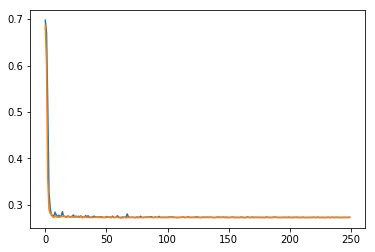

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

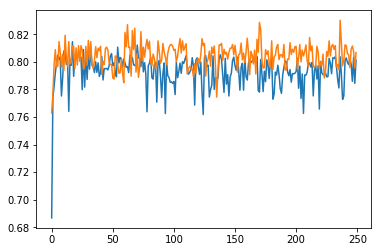

In [47]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

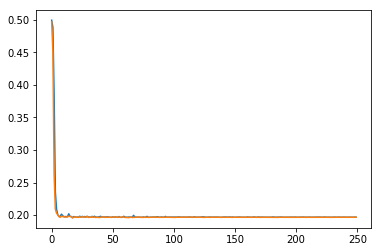

In [48]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [34]:
# plot_model(vae, to_file='model.png')

In [ ]:
plt.plot(x_train[0,:100,:])

In [ ]:
result.shape

In [ ]:
n1 = 30
i = 0
plt.subplot(211)
plt.plot(np.arange(n1), results[i][:n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)
plt.subplot(212)

plt.plot(np.arange(n1), x_train[i, :n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

In [ ]:
mid = midi.decode_track(context, result)
dn = config.dataset_dir
# io.export_midifile(mid, dn + 'song_seq-seq.mid')

In [ ]:
results = []
latent_samples = []
for seq in x_test[-2:]:
    encoded = encode_sequence(np.stack([seq]))
    latent_samples.append(encoded)
    result = decode_sequence(encoded, encoder_model, decoder_model)
    results.append(result)
results[0].shape

In [ ]:
len(encoded)

In [ ]:
encoded[0].shape

In [ ]:
plt.plot(encoded[0][0,:10])
plt.plot(encoded[1][0,:10])

In [ ]:
e = np.array(latent_samples)
e.shape

In [ ]:
# reduce dimensionality
# e = e.reshape(e.shape[0],2,e.shape[-1])
e.shape

In [ ]:
e1.mean(axis=0).shape

In [ ]:
# new = e.transpose().mean(axis=1).transpose()
e1 = e[:,0] # state h
e2 = e[:,1] # state c
new = [e1.mean(axis=0), e2.mean(axis=0)]
# new = [[e[:,i].mean(axis=0)] for i in [0,1]]
plt.plot(new[0][0][:10])
len(new)

In [ ]:
e1.mean(axis=0).shape

In [ ]:
l[0].shape

In [ ]:
l = latent_samples[0]
len(l) # latent_sample :: (x,1,64)

In [ ]:
# new_ = decode_sequence(latent_samples[0], encoder_model, decoder_model)
new_ = decode_sequence(new, encoder_model, decoder_model)

In [ ]:
new_.shape

In [ ]:
plt.plot(new_[:100])

In [ ]:
plt.plot(results[0][:100])

In [ ]:
# results[0]

In [ ]:
mid_new = midi.decode_track(context, results[0])
io.export_midifile(mid_new, config.export_dir + 'real_mid_new_lstm.mid')

In [ ]:
x_test.shape

In [ ]:
# x_test, y_test = gen_xy_sin_to_f(3, f=2)

In [ ]:
results = model.predict([x_test,x_test])
results.shape

In [ ]:
# the 'true' results
i = 0
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],y_test[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
# predicted results
i = 0
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 2
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 0
selection = 1
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)